# Auckland Hotel Advisory

Analysis

### 3.0 Install and Import libraries

In [32]:
!pip install geocoder
!pip install geopy
!pip install folium

In [41]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import geocoder # Talks to geocoding APIs and returns coordinates
import json # library to handle JSON files
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Matplotlib version:  3.1.1
Libraries imported.


### 3.1 Scrape a list of suburbs in Auckland from the internet

In [2]:
#Location of suburb list
url='https://geographic.org/streetview/new_zealand/auckland/auckland/index.html'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <ul>..</ul> of HTML
ak_elements = doc.xpath('//ul')

In [3]:
#Check length of table returned
[len(T) for T in ak_elements[:1]]

[162]

In [4]:
#Parse the table header
ak_elements = doc.xpath('//ul')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in ak_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name))

1:"Albany"
2:"Albany Heights"
3:"Alfriston"
4:"Auckland Airport"
5:"Auckland Central"
6:"Avondale"
7:"Bayswater"
8:"Bayview"
9:"Beach Haven"
10:"Beachlands"
11:"Belmont"
12:"Birkdale"
13:"Birkenhead"
14:"Blockhouse Bay"
15:"Botany Downs"
16:"Browns Bay"
17:"Bucklands Beach"
18:"Burswood"
19:"Campbells Bay"
20:"Castor Bay"
21:"Chatswood"
22:"Clendon Park"
23:"Clover Park"
24:"Cockle Bay"
25:"Cornwallis"
26:"Dannemora"
27:"Devonport"
28:"East Tamaki"
29:"East Tamaki Heights"
30:"Eastern Beach"
31:"Eden Terrace"
32:"Ellerslie"
33:"Epsom"
34:"Fairview Heights"
35:"Farm Cove"
36:"Favona"
37:"Flat Bush"
38:"Forrest Hill"
39:"Freemans Bay"
40:"Glen Eden"
41:"Glen Innes"
42:"Glendene"
43:"Glendowie"
44:"Glenfield"
45:"Golflands"
46:"Goodwood Heights"
47:"Grafton"
48:"Green Bay"
49:"Greenhithe"
50:"Greenlane"
51:"Grey Lynn"
52:"Half Moon Bay"
53:"Hauraki"
54:"Henderson"
55:"Henderson Valley"
56:"Herald Island"
57:"Herne Bay"
58:"Highland Park"
59:"Hillcrest"
60:"Hillsborough"
61:"Hobsonville"
6

In [5]:
# Convert to List
for j in range(0,len(ak_elements)):
    #T is our j'th row
    T=ak_elements[j]

In [6]:
len(col)

162

### 3.2 Get coordinates for Auckland suburbs and parse into a Pandas Dataframe

Using the ARGIS geocoder because google wasn't working (possibly due to authentication requirement)

In [7]:
#Function to get coordinates
def coord_finder(location):
    # initialize your variable to None
    lat_lng_coords = None
    attempts = 0
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Auckland'.format(location))
      lat_lng_coords = g.latlng
      attempts += 1
      print(attempts)
      if attempts >=2: 
        break
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude, longitude

#test


a = coord_finder('Sandringham')
a

1


(-36.887782372999936, 174.7366463080001)

In [61]:
rows_list = []
for location in col:
        dict1 = {}
        lat, long = coord_finder(location)
        dict1.update({'location':location, 'latitude':lat, 'longitude':long}) 
        rows_list.append(dict1)
        print(location, lat, long, len(rows_list))
coords = pd.DataFrame(rows_list)            

1
Albany -36.73427200799995 174.69928106500004 1
1
Albany Heights -36.716018807999944 174.69289730600008 2
1
Alfriston -37.010493372999974 174.9408516090001 3
1
Auckland Airport -37.008059999999944 174.79167000000007 4
1
Auckland Central -36.84839904099994 174.76438785300002 5
1
Avondale -36.89044821899995 174.6870174820001 6
1
Bayswater -36.80819999999994 174.77019000000007 7
1
Bayview -36.77452705999997 174.7090190230001 8
1
Beach Haven -36.78819999999996 174.68019000000004 9
1
Beachlands -36.90813850699993 175.01600573000007 10
1
Belmont -36.80523647199993 174.788186794 11
1
Birkdale -36.797416829999975 174.70436862300005 12
1
Birkenhead -36.80892881099993 174.72194536900008 13
1
Blockhouse Bay -36.92819999999995 174.70019000000002 14
1
Botany Downs -36.90945304999997 174.9170680730001 15
1
Browns Bay -36.71926010899995 174.73666409700002 16
1
Bucklands Beach -36.858199999999954 174.90019000000007 17
1
Burswood -36.92439996699994 174.89716745400005 18
1
Campbells Bay -36.74957706799

In [62]:
coords.head()

,latitude,location,longitude
0,-36.734272,Albany,174.699281
1,-36.716019,Albany Heights,174.692897
2,-37.010493,Alfriston,174.940852
3,-37.008060,Auckland Airport,174.791670
4,-36.848399,Auckland Central,174.764388


In [44]:
len(coords)

162

#### Create a map to see what we have

In [65]:
address = 'Auckland'
geolocator = Nominatim(user_agent="nz_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Auckland are {}, {}.'.format(latitude, longitude))

# create map of Auckland using latitude and longitude values
map_Auckland = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location in zip(coords['latitude'], coords['longitude'], coords['location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Auckland)  
    
map_Auckland

The geograpical coordinate of Auckland are -36.852095, 174.7631803.


From visual inspection:
* Manurewa east labelled as 'Index' (row index 64)
* Green Bay at wrong coordinates (row index 47). Should be Lat -36.924329636 Long 174.684330596
* Westmere at wrong coordinates (row index 157). Should be Lat -36.8499966 Long 174.7166638

In [71]:
coords.iloc[64, coords.columns.get_loc('location')] = 'Manurewa East'
coords.iloc[47, coords.columns.get_loc('latitude')] = -36.924329636
coords.iloc[47, coords.columns.get_loc('longitude')] = 174.684330596
coords.iloc[157, coords.columns.get_loc('latitude')] = -36.8499966
coords.iloc[157, coords.columns.get_loc('longitude')] = 174.7166638

In [87]:
coords.iloc[157,0:3]

latitude       -36.85
location     Westmere
longitude     174.717
Name: 157, dtype: object

In [82]:
#Save data for loading later if needed
coords.to_csv('coords.csv')
coords.to_pickle("./coords.pkl")

### 3.3 Create an API call to FourSquare, using the suburb list to get all hotels in each suburb into a Python Pandas dataframe

Reload coords dataframe from pickle

In [64]:
coords = pd.read_pickle("coords.pkl")

In [36]:
coords.head()

,latitude,location,longitude
0,-36.734272,Albany,174.699281
1,-36.716019,Albany Heights,174.692897
2,-37.010493,Alfriston,174.940852
3,-37.008060,Auckland Airport,174.791670
4,-36.848399,Auckland Central,174.764388


Foursquare credentials

In [6]:
CLIENT_ID = '4XUF0MUT2N5AN1WJ3TWWDWZZYIWPSS41DHOXJ2ONFQY4VBTW' # your Foursquare ID
CLIENT_SECRET = 'ZLS5TCUME3U1VHVA5SNKPUGSKT3BT1FEXCZHHN0KKFDDOZFT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 4XUF0MUT2N5AN1WJ3TWWDWZZYIWPSS41DHOXJ2ONFQY4VBTW
CLIENT_SECRET:ZLS5TCUME3U1VHVA5SNKPUGSKT3BT1FEXCZHHN0KKFDDOZFT


Test with first suburb

In [7]:
coords.loc[0, 'location']

'Albany'

In [13]:
neighborhood_latitude = coords.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = coords.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = coords.loc[0, 'location'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Albany are -36.73427200799995, 174.69928106500004.


Create URL for first suburb

In [14]:
radius = 1000
LIMIT = 50
category_id = '4bf58dd8d48988d1fa931735' # Hotels 
#search_query = &query={} search_query,

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    category_id)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=4XUF0MUT2N5AN1WJ3TWWDWZZYIWPSS41DHOXJ2ONFQY4VBTW&client_secret=ZLS5TCUME3U1VHVA5SNKPUGSKT3BT1FEXCZHHN0KKFDDOZFT&v=20180605&ll=-36.73427200799995,174.69928106500004&radius=1000&limit=50&categoryId=4bf58dd8d48988d1fa931735'

Make request for first suburb

In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eaccd483907e7001be5083b'},
 'response': {'headerLocation': 'Albany',
  'headerFullLocation': 'Albany, Auckland',
  'headerLocationGranularity': 'neighborhood',
  'query': 'hotel',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': -36.725271998999936,
    'lng': 174.71049020263462},
   'sw': {'lat': -36.74327201699996, 'lng': 174.68807192736546}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c9071aeb6d1a14341d4c30f',
       'name': 'Albany Oaks',
       'location': {'lat': -36.73960179999999,
        'lng': 174.70277481,
        'labeledLatLngs': [{'label': 'display',
          'lat': -36.73960179999999,
          'lng': 174.70277481}],
        'distance': 670,
        'cc': 'NZ',
        'country': 'New Zealand',
        '

Function for getting data for all suburbs

In [295]:
radius = 1000
LIMIT = 50
category_id = '4bf58dd8d48988d1fa931735' # Hotels 


def getNearbyVenues(names, lat, lng, radius=1000, LIMIT=100):
    
    venues_list=[]
    iteration = 0
    for name, lat, lng in zip(names, lat, lng):
        print(name, end = " ")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category_id)
            
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        #print(venues_list[iteration])
        #iteration += 1
    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude',
                  'venue_id',           
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

Get data for all suburbs

In [354]:
auckland_venues = getNearbyVenues(names=coords['location'],
                                   lat=coords['latitude'],
                                   lng=coords['longitude'])

Albany Albany Heights Alfriston Auckland Airport Auckland Central Avondale Bayswater Bayview Beach Haven Beachlands Belmont Birkdale Birkenhead Blockhouse Bay Botany Downs Browns Bay Bucklands Beach Burswood Campbells Bay Castor Bay Chatswood Clendon Park Clover Park Cockle Bay Cornwallis Dannemora Devonport East Tamaki East Tamaki Heights Eastern Beach Eden Terrace Ellerslie Epsom Fairview Heights Farm Cove Favona Flat Bush Forrest Hill Freemans Bay Glen Eden Glen Innes Glendene Glendowie Glenfield Golflands Goodwood Heights Grafton Green Bay Greenhithe Greenlane Grey Lynn Half Moon Bay Hauraki Henderson Henderson Valley Herald Island Herne Bay Highland Park Hillcrest Hillsborough Hobsonville Howick Huia Huntington Park Manurewa East Kelston Kingsland Kohimarama Laingholm Long Bay Lucas Heights Lynfield Mairangi Bay Mangere Mangere Bridge Mangere East Manukau Manurewa Manurewa East Maraetai Massey Meadowbank Mechanics Bay Mellons Bay Milford Mission Bay Mount Albert Mount Eden Mount R

In [358]:
#Save data for loading later if needed
auckland_venues.to_csv('./auckland_venues_raw.csv')
auckland_venues.to_pickle("./auckland_venues_raw.pkl")

In [355]:
auckland_venues.head(10)

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category
0,Albany,-36.734272,174.699281,4c9071aeb6d1a14341d4c30f,Albany Oaks,-36.739602,174.702775,Hotel
1,Albany,-36.734272,174.699281,4ed744026c25acaaba8066fe,Albany Executive Motor Inn,-36.732644,174.710302,Hotel
2,Albany,-36.734272,174.699281,507ba83de4b065f1de8fda22,Quest Apartments Albany,-36.726031,174.695341,Motel
3,Albany,-36.734272,174.699281,509b90bde4b08fb1c9b1c326,UniHouse,-36.738379,174.691921,Hostel
4,Albany Heights,-36.716019,174.692897,4d198a5625cda1433dfe87d6,Point Ridge Resort,-36.718555,174.697990,Resort
5,Auckland Airport,-37.008060,174.791670,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,-37.003723,174.783203,Hotel
6,Auckland Airport,-37.008060,174.791670,505c2f04e4b00e37996420bf,Chateau Commode,-37.005419,174.788198,Hotel
7,Auckland Airport,-37.008060,174.791670,5d257f2b9cff7500239c86aa,BookaCampa Campervan Hire,-37.005368,174.781858,Vacation Rental
8,Auckland Central,-36.848399,174.764388,4b873417f964a52037b631e3,Rydges Auckland,-36.847389,174.762850,Hotel
9,Auckland Central,-36.848399,174.764388,4c29e338e19720a14c1bfa58,Hotel DeBrett,-36.846834,174.766980,Hotel


In [30]:
auckland_venues.describe(include = 'all')

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category
count,207,207.000000,207.000000,207,207,207.000000,207.000000,207
unique,59,NaN,NaN,207,205,NaN,NaN,10
top,Auckland Central,NaN,NaN,4e0e9a41ae603a50b5450d19,The Esplanade Hotel,NaN,NaN,Hotel
freq,78,NaN,NaN,1,2,NaN,NaN,116
mean,NaN,-36.867802,174.774236,NaN,NaN,-36.867944,174.774767,NaN
std,NaN,0.057802,0.051081,NaN,NaN,0.057823,0.050739,NaN
min,NaN,-37.025213,174.622935,NaN,NaN,-37.028207,174.621313,NaN
25%,NaN,-36.888454,174.761264,NaN,NaN,-36.888649,174.759524,NaN
50%,NaN,-36.848399,174.764388,NaN,NaN,-36.855350,174.765982,NaN
75%,NaN,-36.848399,174.779750,NaN,NaN,-36.846892,174.782806,NaN


In [357]:
auckland_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 8 columns):
neighborhood              287 non-null object
neighborhood_latitude     287 non-null float64
neighborhood_longitude    287 non-null float64
venue_id                  287 non-null object
venue                     287 non-null object
venue_latitude            287 non-null float64
venue_longitude           287 non-null float64
venue_category            287 non-null object
dtypes: float64(4), object(4)
memory usage: 18.0+ KB


Clean up by removing duplicates

In [5]:
auckland_venues = auckland_venues.drop_duplicates(subset=['venue_id'], keep="first")
auckland_venues.reset_index(drop=True)

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category
0,Albany,-36.734272,174.699281,4c9071aeb6d1a14341d4c30f,Albany Oaks,-36.739602,174.702775,Hotel
1,Albany,-36.734272,174.699281,4ed744026c25acaaba8066fe,Albany Executive Motor Inn,-36.732644,174.710302,Hotel
2,Albany,-36.734272,174.699281,507ba83de4b065f1de8fda22,Quest Apartments Albany,-36.726031,174.695341,Motel
3,Albany,-36.734272,174.699281,509b90bde4b08fb1c9b1c326,UniHouse,-36.738379,174.691921,Hostel
4,Albany Heights,-36.716019,174.692897,4d198a5625cda1433dfe87d6,Point Ridge Resort,-36.718555,174.697990,Resort
5,Auckland Airport,-37.008060,174.791670,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,-37.003723,174.783203,Hotel
6,Auckland Airport,-37.008060,174.791670,505c2f04e4b00e37996420bf,Chateau Commode,-37.005419,174.788198,Hotel
7,Auckland Airport,-37.008060,174.791670,5d257f2b9cff7500239c86aa,BookaCampa Campervan Hire,-37.005368,174.781858,Vacation Rental
8,Auckland Central,-36.848399,174.764388,4b873417f964a52037b631e3,Rydges Auckland,-36.847389,174.762850,Hotel
9,Auckland Central,-36.848399,174.764388,4c29e338e19720a14c1bfa58,Hotel DeBrett,-36.846834,174.766980,Hotel


In [362]:
auckland_venues.describe(include = 'all')

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category
count,207,207.000000,207.000000,207,207,207.000000,207.000000,207
unique,59,NaN,NaN,207,205,NaN,NaN,10
top,Auckland Central,NaN,NaN,4cb810e7035d236a7d1fca4e,Emerald Inn Takapuna,NaN,NaN,Hotel
freq,78,NaN,NaN,1,2,NaN,NaN,116
mean,NaN,-36.867802,174.774236,NaN,NaN,-36.867944,174.774767,NaN
std,NaN,0.057802,0.051081,NaN,NaN,0.057823,0.050739,NaN
min,NaN,-37.025213,174.622935,NaN,NaN,-37.028207,174.621313,NaN
25%,NaN,-36.888454,174.761264,NaN,NaN,-36.888649,174.759524,NaN
50%,NaN,-36.848399,174.764388,NaN,NaN,-36.855350,174.765982,NaN
75%,NaN,-36.848399,174.779750,NaN,NaN,-36.846892,174.782806,NaN


In [29]:
av_grp=auckland_venues.groupby(by='neighborhood', sort=True).count()
av_grp.sort_values(axis=0, by='venue_id', ascending=False, inplace=True)
av_grp.head(15)

,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category
neighborhood,,,,,,,
Auckland Central,78,78,78,78,78,78,78
Eden Terrace,9,9,9,9,9,9,9
Epsom,8,8,8,8,8,8,8
Newmarket,7,7,7,7,7,7,7
Mangere,6,6,6,6,6,6,6
Grafton,5,5,5,5,5,5,5
Mount Eden,5,5,5,5,5,5,5
Devonport,4,4,4,4,4,4,4
Kingsland,4,4,4,4,4,4,4


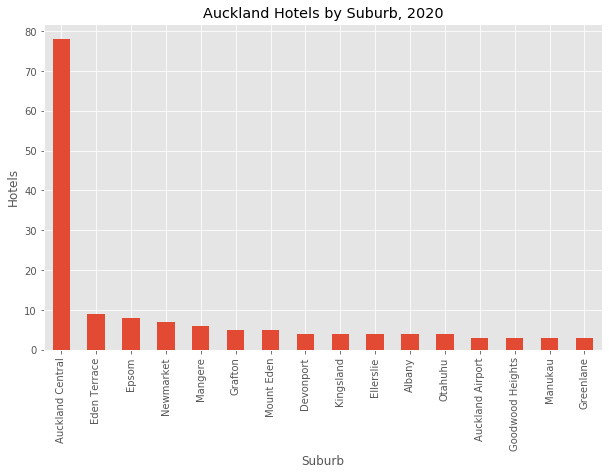

In [51]:
# plot data
av_plot = av_grp.loc[av_grp['venue'] >= 3,'venue']
av_plot.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Hotels') # add y-label to the plot
plt.title('Auckland Hotels by Suburb, 2020') # add title to the plot

plt.show()

In [368]:
#Save data for loading later if needed
auckland_venues.to_csv('./auckland_venues.csv')
auckland_venues.to_pickle("./auckland_venues.pkl")

### 3.4 Create an API call to FourSquare, using the hotel list to get venues checked into after the hotel

Open the Auckland venues dataframe

In [4]:
auckland_venues = pd.read_pickle("auckland_venues.pkl")

Get data for one venue to check.

URL format

GET https://api.foursquare.com/v2/venues/VENUE_ID/nextvenues?&client_id=XXXX&client_secret=XXXX

In [93]:
venue_id = '4b873417f964a52037b631e3'
url_next = 'https://api.foursquare.com/v2/venues/{}/nextvenues?&client_id={}&client_secret={}&v={}'.format(
    venue_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION 
    )
url_next

'https://api.foursquare.com/v2/venues/4b873417f964a52037b631e3/nextvenues?&client_id=4XUF0MUT2N5AN1WJ3TWWDWZZYIWPSS41DHOXJ2ONFQY4VBTW&client_secret=ZLS5TCUME3U1VHVA5SNKPUGSKT3BT1FEXCZHHN0KKFDDOZFT&v=20180605'

In [193]:
results2 = requests.get(url_next).json()
results2

{'meta': {'code': 200, 'requestId': '5ead00af9c6f59001bdd6532'},
 'response': {'nextVenues': {'count': 5,
   'items': [{'id': '4b4fd256f964a520ad1627e3',
     'name': 'Sky Tower',
     'location': {'address': '93 Federal St.',
      'crossStreet': 'at Victoria St. W',
      'lat': -36.848447397808584,
      'lng': 174.7622861329084,
      'labeledLatLngs': [{'label': 'display',
        'lat': -36.848447397808584,
        'lng': 174.7622861329084}],
      'postalCode': '1010',
      'cc': 'NZ',
      'city': 'Auckland',
      'state': 'Auckland',
      'country': 'New Zealand',
      'formattedAddress': ['93 Federal St. (at Victoria St. W)',
       'Auckland 1010',
       'New Zealand']},
     'categories': [{'id': '4bf58dd8d48988d12d941735',
       'name': 'Monument / Landmark',
       'pluralName': 'Monuments / Landmarks',
       'shortName': 'Landmark',
       'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/government_monument_',
        'suffix': '.png'},
       

Create function to iterate over all venues

In [366]:
def getNextVenues(venue_id, venue, neigh):
    
    venues_next_list=[]
    iteration = 0
    #print("Enter loop")
    
    for ven_id, ven in zip(venue_id, venue):
        # create the API request URL
        url_next = 'https://api.foursquare.com/v2/venues/{}/nextvenues?&client_id={}&client_secret={}&v={}'.format(
            ven_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION 
            )
        results_next=[]    
        # make the GET request
        results_next = requests.get(url_next).json()['response']['nextVenues']['items']
        print("Request sent ", " ", ven, " ", iteration)
        #print(results_next)
        #print(len(results_next))
        #print(type(results_next))   
        iteration += 1
        
    # return only relevant information for each nearby venue
        for v in results_next:
            #print(v)
            venues_next_list.append([(
                ven_id,
                ven, 
                v['id'],
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']
                )])
    next_venues = pd.DataFrame([item for venues_next_list in venues_next_list for item in venues_next_list])
    next_venues.columns = ['venue_id',
                        'venue',
                        'next_venue_id',           
                        'next_venue', 
                        'next_venue_latitude', 
                        'next_venue_longitude', 
                        'next_venue_category']
    return(next_venues)

In [367]:
next_venues = getNextVenues(venue_id=auckland_venues['venue_id'],
                           venue=auckland_venues['venue'],
                           neigh=auckland_venues['neighborhood'])

Request sent    Albany Oaks   0
Request sent    Albany Executive Motor Inn   1
Request sent    Quest Apartments Albany   2
Request sent    UniHouse   3
Request sent    Point Ridge Resort   4
Request sent    Novotel Auckland Airport   5
Request sent    Chateau Commode   6
Request sent    BookaCampa Campervan Hire   7
Request sent    Rydges Auckland   8
Request sent    Hotel DeBrett   9
Request sent    SKYCITY Grand Hotel   10
Request sent    Pullman Auckland Hotel   11
Request sent    Four Points by Sheraton Auckland   12
Request sent    SKYCITY Hotel   13
Request sent    M Social Auckland   14
Request sent    Hilton   15
Request sent    Stamford Plaza Auckland   16
Request sent    Scenic Hotel   17
Request sent    Grand Millennium Auckland   18
Request sent    Hotel Grand Chancellor   19
Request sent    Waldorf Stadium Apartments Hotel   20
Request sent    Adina Apartments   21
Request sent    Crowne Plaza Auckland   22
Request sent    Barclay Suites   23
Request sent    CityLife Auckl

In [369]:
next_venues.head()

,venue_id,venue,next_venue_id,next_venue,next_venue_latitude,next_venue_longitude,next_venue_category
0,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,4de0a9c37d8b84d5dc723835,The Square Restaurant,-37.004158,174.783010,Restaurant
1,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,4d3f55c6255d8cfa902b5a05,Hayama Sushi & Noodle,-37.005054,174.783084,Sushi Restaurant
2,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,4bd54ffe4e32d13a89acc080,Countdown,-36.997672,174.788728,Supermarket
3,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,4e378ea6e4cdedd4a1b32d1b,Mac's Down Under Bar & Cafe,-37.004939,174.783034,Bar
4,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,4eb18dde8b813ed008295f99,Atomic Coffee,-37.005060,174.783088,Café


In [370]:
#Save data for loading later if needed
next_venues.to_csv('./next_venues.csv')
next_venues.to_pickle("./next_venues.pkl")

### 3.5 Restructure the dataframe so their is one row per hotel and each category is a column 

Use one-hot coding to put each next_venues category in a row and have one row per Hotel

In [195]:
#Load next_venues dataframe if required
#next_venues = pd.read_pickle("auckland_venues.pkl")

In [371]:
# one hot encoding
auckland_onehot = pd.get_dummies(next_venues[['next_venue_category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
auckland_onehot['venue'] = next_venues['venue'] 

# move venue column to the first column
fixed_columns = [auckland_onehot.columns[-1]] + list(auckland_onehot.columns[:-1])
auckland_onehot = auckland_onehot[fixed_columns]

auckland_onehot.head()

,venue,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,Casino,Coffee Shop,Deli / Bodega,Diner,Fast Food Restaurant,Food,Food Court,French Restaurant,Garden,Harbor / Marina,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Malay Restaurant,Monument / Landmark,Park,Pizza Place,Plaza,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
0,Novotel Auckland Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Novotel Auckland Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Novotel Auckland Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Novotel Auckland Airport,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Novotel Auckland Airport,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [372]:
auckland_onehot.shape

(152, 44)

Group by venue

In [383]:
auckland_onehot_grp = auckland_onehot.groupby(by = 'venue', axis=0).sum()
auckland_onehot_grp

,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,Casino,Coffee Shop,Deli / Bodega,Diner,Fast Food Restaurant,Food,Food Court,French Restaurant,Garden,Harbor / Marina,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Malay Restaurant,Monument / Landmark,Park,Pizza Place,Plaza,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adina Apartments,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Amora Hotel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Ascotia Off Queen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Auckland City Hotel,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Barclay Suites,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Base Backpackers Auckland,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Best Western President Hotel,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CityLife Auckland,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Cordis Auckland by Langham Hospitality Group (Cordis Auckland),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [384]:
auckland_onehot_grp.describe()

,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,Casino,Coffee Shop,Deli / Bodega,Diner,Fast Food Restaurant,Food,Food Court,French Restaurant,Garden,Harbor / Marina,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Malay Restaurant,Monument / Landmark,Park,Pizza Place,Plaza,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.040000,0.040000,0.020000,0.020000,0.220000,0.020000,0.180000,0.040000,0.020000,0.22000,0.080000,0.100000,0.060000,0.020000,0.040000,0.020000,0.020000,0.060000,0.020000,0.180000,0.020000,0.040000,0.020000,0.040000,0.060000,0.060000,0.500000,0.080000,0.020000,0.020000,0.020000,0.320000,0.020000,0.020000,0.060000,0.020000,0.020000,0.020000,0.180000,0.020000,0.020000,0.020000,0.020000
std,0.197949,0.197949,0.141421,0.141421,0.418452,0.141421,0.388088,0.197949,0.141421,0.46467,0.274048,0.303046,0.239898,0.141421,0.197949,0.141421,0.141421,0.239898,0.141421,0.388088,0.141421,0.197949,0.141421,0.197949,0.239898,0.239898,0.505076,0.274048,0.141421,0.141421,0.141421,0.512696,0.141421,0.141421,0.239898,0.141421,0.141421,0.141421,0.388088,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.6 Merge the Hotel and Venues dataframes

In [386]:
auckland_merged = auckland_venues
auckland_merged = auckland_merged.join(auckland_onehot_grp, on='venue')
auckland_merged.head(10) # check the last columns!

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,Casino,Coffee Shop,Deli / Bodega,Diner,Fast Food Restaurant,Food,Food Court,French Restaurant,Garden,Harbor / Marina,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Malay Restaurant,Monument / Landmark,Park,Pizza Place,Plaza,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
0,Albany,-36.734272,174.699281,4c9071aeb6d1a14341d4c30f,Albany Oaks,-36.739602,174.702775,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albany,-36.734272,174.699281,4ed744026c25acaaba8066fe,Albany Executive Motor Inn,-36.732644,174.710302,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albany,-36.734272,174.699281,507ba83de4b065f1de8fda22,Quest Apartments Albany,-36.726031,174.695341,Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albany,-36.734272,174.699281,509b90bde4b08fb1c9b1c326,UniHouse,-36.738379,174.691921,Hostel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albany Heights,-36.716019,174.692897,4d198a5625cda1433dfe87d6,Point Ridge Resort,-36.718555,174.697990,Resort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Auckland Airport,-37.008060,174.791670,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,-37.003723,174.783203,Hotel,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,Auckland Airport,-37.008060,174.791670,505c2f04e4b00e37996420bf,Chateau Commode,-37.005419,174.788198,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Auckland Airport,-37.008060,174.791670,5d257f2b9cff7500239c86aa,BookaCampa Campervan Hire,-37.005368,174.781858,Vacation Rental,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Auckland Central,-36.848399,174.764388,4b873417f964a52037b631e3,Rydges Auckland,-36.847389,174.762850,Hotel,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,Auckland Central,-36.848399,174.764388,4c29e338e19720a14c1bfa58,Hotel DeBrett,-36.846834,174.766980,Hotel,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [387]:
auckland_merged.shape

(207, 51)

In [388]:
auckland_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 286
Data columns (total 51 columns):
neighborhood              207 non-null object
neighborhood_latitude     207 non-null float64
neighborhood_longitude    207 non-null float64
venue_id                  207 non-null object
venue                     207 non-null object
venue_latitude            207 non-null float64
venue_longitude           207 non-null float64
venue_category            207 non-null object
Art Gallery               51 non-null float64
Asian Restaurant          51 non-null float64
Australian Restaurant     51 non-null float64
Bagel Shop                51 non-null float64
Bar                       51 non-null float64
Beach                     51 non-null float64
Beer Bar                  51 non-null float64
Breakfast Spot            51 non-null float64
Buffet                    51 non-null float64
Café                      51 non-null float64
Casino                    51 non-null float64
Coffee Shop      

In [389]:
pd.options.display.max_columns = None
auckland_merged.describe(include='all')

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,Casino,Coffee Shop,Deli / Bodega,Diner,Fast Food Restaurant,Food,Food Court,French Restaurant,Garden,Harbor / Marina,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Malay Restaurant,Monument / Landmark,Park,Pizza Place,Plaza,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
count,207,207.000000,207.000000,207,207,207.000000,207.000000,207,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
unique,59,NaN,NaN,207,205,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Auckland Central,NaN,NaN,4cb810e7035d236a7d1fca4e,Emerald Inn Takapuna,NaN,NaN,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,78,NaN,NaN,1,2,NaN,NaN,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-36.867802,174.774236,NaN,NaN,-36.867944,174.774767,NaN,0.039216,0.039216,0.019608,0.019608,0.215686,0.019608,0.176471,0.039216,0.019608,0.215686,0.078431,0.098039,0.058824,0.019608,0.039216,0.019608,0.019608,0.058824,0.019608,0.176471,0.019608,0.039216,0.019608,0.039216,0.058824,0.058824,0.490196,0.078431,0.019608,0.019608,0.019608,0.313725,0.039216,0.019608,0.058824,0.019608,0.019608,0.019608,0.176471,0.019608,0.019608,0.019608,0.019608
std,NaN,0.057802,0.051081,NaN,NaN,0.057823,0.050739,NaN,0.196039,0.196039,0.140028,0.140028,0.415390,0.140028,0.385013,0.196039,0.140028,0.461030,0.271524,0.300327,0.237635,0.140028,0.196039,0.140028,0.140028,0.237635,0.140028,0.385013,0.140028,0.196039,0.140028,0.196039,0.237635,0.237635,0.504878,0.271524,0.140028,0.140028,0.140028,0.509517,0.196039,0.140028,0.237635,0.140028,0.140028,0.140028,0.385013,0.140028,0.140028,0.140028,0.140028
min,NaN,-37.025213,174.622935,NaN,NaN,-37.028207,174.621313,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,-36.888454,174.761264,NaN,NaN,-36.888649,174.759524,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,-36.848399,174.764388,NaN,NaN,-36.855350,174.765982,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [390]:
#Save data for loading later if needed
auckland_merged.to_csv('./auckland_merged.csv')
auckland_merged.to_pickle("./auckland_merged.pkl")

### 3.7 Conduct a cluster analysis on the Hotels, using the venue categories as the descriptors

In [13]:
auckland_merged = pd.read_pickle("./auckland_merged.pkl")

Create dataframe and drop rows with no data

In [14]:
auckland_valid = auckland_merged.dropna(how='all', axis=1)
auckland_valid = auckland_valid.dropna(how='any', axis=0)
auckland_clustering = auckland_valid.drop(['neighborhood','neighborhood_latitude', 'neighborhood_longitude', 'venue_id', 'venue', 'venue_latitude', 'venue_longitude', 'venue_category'],  1)
auckland_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 5 to 279
Data columns (total 43 columns):
Art Gallery              51 non-null float64
Asian Restaurant         51 non-null float64
Australian Restaurant    51 non-null float64
Bagel Shop               51 non-null float64
Bar                      51 non-null float64
Beach                    51 non-null float64
Beer Bar                 51 non-null float64
Breakfast Spot           51 non-null float64
Buffet                   51 non-null float64
Café                     51 non-null float64
Casino                   51 non-null float64
Coffee Shop              51 non-null float64
Deli / Bodega            51 non-null float64
Diner                    51 non-null float64
Fast Food Restaurant     51 non-null float64
Food                     51 non-null float64
Food Court               51 non-null float64
French Restaurant        51 non-null float64
Garden                   51 non-null float64
Harbor / Marina          51 non-null floa

In [15]:
auckland_clustering

,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,Café,...,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
auckland_clustering.to_csv('./auckland_clustering.csv')
auckland_clustering.to_pickle('./auckland_clustering.pkl')
auckland_valid.to_csv('./auckland_valid.csv')
auckland_valid.to_pickle('./auckland_valid.pkl')

Run clustering algorithm

In [19]:
auckland_clustering = pd.read_pickle("auckland_clustering.pkl")

In [20]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(auckland_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [21]:
# add clustering labels
auckland_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

In [22]:
auckland_clustering

,Cluster Labels,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bar,Beach,Beer Bar,Breakfast Spot,Buffet,...,Seafood Restaurant,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery
5,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Merge results back into the merged dataframe

In [42]:
auckland_merged2 = auckland_merged
auckland_clustering2 = auckland_clustering[['Cluster Labels']]
# merge auckland_merged with auckland_clustering
auckland_merged2 = auckland_merged2.merge(auckland_clustering2, how = 'outer', left_index=True, right_index=True)
auckland_merged2['Cluster Labels'] = auckland_merged2['Cluster Labels'].fillna(6)
auckland_merged2# check the last columns!

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue_id,venue,venue_latitude,venue_longitude,venue_category,Art Gallery,Asian Restaurant,...,Shopping Mall,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Winery,Cluster Labels
0,Albany,-36.734272,174.699281,4c9071aeb6d1a14341d4c30f,Albany Oaks,-36.739602,174.702775,Hotel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1,Albany,-36.734272,174.699281,4ed744026c25acaaba8066fe,Albany Executive Motor Inn,-36.732644,174.710302,Hotel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2,Albany,-36.734272,174.699281,507ba83de4b065f1de8fda22,Quest Apartments Albany,-36.726031,174.695341,Motel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,Albany,-36.734272,174.699281,509b90bde4b08fb1c9b1c326,UniHouse,-36.738379,174.691921,Hostel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,Albany Heights,-36.716019,174.692897,4d198a5625cda1433dfe87d6,Point Ridge Resort,-36.718555,174.697990,Resort,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
5,Auckland Airport,-37.008060,174.791670,4dce1684fa7664b7c69fd605,Novotel Auckland Airport,-37.003723,174.783203,Hotel,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
6,Auckland Airport,-37.008060,174.791670,505c2f04e4b00e37996420bf,Chateau Commode,-37.005419,174.788198,Hotel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
7,Auckland Airport,-37.008060,174.791670,5d257f2b9cff7500239c86aa,BookaCampa Campervan Hire,-37.005368,174.781858,Vacation Rental,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
8,Auckland Central,-36.848399,174.764388,4b873417f964a52037b631e3,Rydges Auckland,-36.847389,174.762850,Hotel,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,Auckland Central,-36.848399,174.764388,4c29e338e19720a14c1bfa58,Hotel DeBrett,-36.846834,174.766980,Hotel,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Map the clusters

In [57]:
latitude = -36.848548
longitude = 174.762123

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(auckland_merged2['venue_latitude'], auckland_merged2['venue_longitude'], auckland_merged2['venue'], auckland_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster <= 5:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.7
            ).add_to(map_clusters)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='grey',
            fill=True,
            fill_color='grey',
            fill_opacity=0.7
            ).add_to(map_clusters)
map_clusters

In [58]:
#saved auckland_merged2 in case it is required later
auckland_merged2.to_csv('./auckland_merged2.csv')
auckland_merged2.to_pickle('./auckland_mwerged2.pkl')

### 3.8 Profile clusters to understand the needs of customers at each hotel cluster

In [56]:
auckland_merged2 = pd.read_pickle('./auckland_mwerged2.pkl')

In [57]:
auckland_summary = auckland_merged2.pivot_table(auckland_merged2,index=["Cluster Labels"], aggfunc=[np.mean],fill_value=0)

In [58]:
auckland_summary

mean                                                    \
               Art Gallery Asian Restaurant Australian Restaurant Bagel Shop   
Cluster Labels                                                                 
0.0               0.000000         0.100000              0.000000   0.000000   
1.0               0.125000         0.000000              0.000000   0.000000   
2.0               0.000000         0.000000              0.000000   0.000000   
3.0               0.000000         0.076923              0.076923   0.000000   
4.0               0.066667         0.000000              0.000000   0.066667   
6.0               0.000000         0.000000              0.000000   0.000000   

                                                                       \
                     Bar     Beach  Beer Bar Breakfast Spot    Buffet   
Cluster Labels                                                          
0.0             0.500000  0.000000  0.600000       0.100000  0.000000   
1.0             0.250000  0.000000  0.000000       0.000000  0.000000   
2.0             0.400000  0.000000  0.000000       0.000000  0.000000   
3.0             0.000000  0.000000  0.076923       0.000000  0.076923   
4.0             0.133333  0.066667  0.133333       0.066667  0.000000   
6.0             0.000000  0.000000  0.000000       0.000000  0.000000   

                                                                    \
                    Café    Casino Coffee Shop Deli / Bodega Diner   
Cluster Labels                                                       
0.0             0.000000  0.300000    0.100000           0.3   0.0   
1.0             1.125000  0.000000    0.125000           0.0   0.0   
2.0             0.200000  0.000000    0.000000           0.0   0.2   
3.0             0.076923  0.076923    0.153846           0.0   0.0   
4.0             0.000000  0.000000    0.066667           0.0   0.0   
6.0             0.000000  0.000000    0.000000           0.0   0.0   

                                                                            \
               Fast Food Restaurant      Food Food Court French Restaurant   
Cluster Labels                                                               
0.0                        0.000000  0.000000      0.000          0.100000   
1.0                        0.000000  0.000000      0.125          0.125000   
2.0                        0.000000  0.000000      0.000          0.000000   
3.0                        0.076923  0.076923      0.000          0.000000   
4.0                        0.066667  0.000000      0.000          0.066667   
6.0                        0.000000  0.000000      0.000          0.000000   

                                                                             \
               Garden Harbor / Marina     Hotel Hotel Bar Indian Restaurant   
Cluster Labels                                                                
0.0               0.0        0.300000  0.000000  0.100000          0.000000   
1.0               0.0        0.125000  0.000000  0.000000          0.000000   
2.0               0.2        0.000000  0.000000  0.000000          0.000000   
3.0               0.0        0.230769  0.000000  0.076923          0.000000   
4.0               0.0        0.133333  0.066667  0.000000          0.066667   
6.0               0.0        0.000000  0.000000  0.000000          0.000000   

                                                                        \
               Italian Restaurant Japanese Restaurant Malay Restaurant   
Cluster Labels                                                           
0.0                      0.000000            0.000000         0.000000   
1.0                      0.000000            0.250000         0.000000   
2.0                      0.000000            0.000000         0.000000   
3.0                      0.153846            0.076923         0.153846   
4.0                      0.000000            0.000000         0.066667   
6.0  

#### Segment 0 Profile

In [65]:
auck_summary0 = auckland_summary.iloc[[0]]
auck_summary0 = auck_summary0.sort_values(0, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')
auck_summary0

mean                                             \
               venue_longitude neighborhood_longitude Monument / Landmark   
Cluster Labels                                                              
0.0                 174.764641             174.764388                 1.0   

                                                                              \
               Restaurant Beer Bar  Bar Casino Deli / Bodega Harbor / Marina   
Cluster Labels                                                                 
0.0                   0.9      0.6  0.5    0.3           0.3             0.3   

                                                                              \
               Supermarket French Restaurant  Pub Asian Restaurant Hotel Bar   
Cluster Labels                                                                 
0.0                    0.2               0.1  0.1              0.1       0.1   

                                                                          \
               Seafood Restaurant Steakhouse Coffee Shop Thai Restaurant   
Cluster Labels                                                             
0.0                           0.1        0.1         0.1             0.1   

                                                                      \
               Breakfast Spot  Spa Stadium Shopping Mall Pizza Place   
Cluster Labels                                                         
0.0                       0.1  0.0     0.0           0.0         0.0   

                                                                     \
               Sushi Restaurant Scenic Lookout Theater Winery Plaza   
Cluster Labels                                                        
0.0                         0.0            0.0     0.0    0.0   0.0   

                                                                            \
               Art Gallery Park Fast Food Restaurant Australian Restaurant   
Cluster Labels                                                               
0.0                    0.0  0.0                  0.0                   0.0   

                                                                         \
               Bagel Shop Beach Buffet Café Malay Restaurant Diner Food   
Cluster Labels                                                            
0.0                   0.0   0.0    0.0  0.0              0.0   0.0  0.0   

                                                                              \
               Food Court Garden Hotel Indian Restaurant Japanese Restaurant   
Cluster Labels                                                                 
0.0                   0.0    0.0   0.0               0.0                 0.0   

                                                                        
               Italian Restaurant venue_latitude neighborhood_latitude  
Cluster Labels                                                          
0.0                           0.0     -36.847407            -36.848399

In [90]:
auckland_merged2[auckland_merged2['Cluster Labels'] == 0].loc[:,'venue']

8                      Rydges Auckland
9                        Hotel DeBrett
10                 SKYCITY Grand Hotel
11              Pullman Auckland Hotel
12    Four Points by Sheraton Auckland
13                       SKYCITY Hotel
15                              Hilton
16             Stamford Plaza Auckland
24                   CityLife Auckland
30                   Heritage Auckland
Name: venue, dtype: object

#### Segment 1 Profile

In [91]:
auck_summary1 = auckland_summary.iloc[[1]]
auck_summary1.sort_values(1, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')

mean                                                 \
               venue_longitude neighborhood_longitude   Café   Bar Restaurant   
Cluster Labels                                                                  
1.0                 174.767365             174.767048  1.125  0.25       0.25   

                                                                   \
               Monument / Landmark Japanese Restaurant Food Court   
Cluster Labels                                                      
1.0                           0.25                0.25      0.125   

                                                                 \
               Shopping Mall Pizza Place   Park Harbor / Marina   
Cluster Labels                                                    
1.0                    0.125       0.125  0.125           0.125   

                                                                               \
               French Restaurant Art Gallery Coffee Shop Fast Food Restaurant   
Cluster Labels                                                                  
1.0                        0.125       0.125       0.125                  0.0   

                                                                          \
               Food Australian Restaurant Winery Theater Thai Restaurant   
Cluster Labels                                                             
1.0             0.0                   0.0    0.0     0.0             0.0   

                                                                     \
               Sushi Restaurant Supermarket Steakhouse Stadium  Spa   
Cluster Labels                                                        
1.0                         0.0         0.0        0.0     0.0  0.0   

                                                                              \
               Bagel Shop Seafood Restaurant Scenic Lookout Beach  Pub Plaza   
Cluster Labels                                                                 
1.0                   0.0                0.0            0.0   0.0  0.0   0.0   

                                                                       \
               Beer Bar Breakfast Spot Buffet Malay Restaurant Casino   
Cluster Labels                                                          
1.0                 0.0            0.0    0.0              0.0    0.0   

                                                                          \
               Asian Restaurant Indian Restaurant Hotel Bar Hotel Garden   
Cluster Labels                                                             
1.0                         0.0               0.0       0.0   0.0    0.0   

                                                                      \
               Deli / Bodega Diner Italian Restaurant venue_latitude   
Cluster Labels                                                         
1.0                      0.0   0.0                0.0     -36.853573   

                                      
               neighborhood_latitude  
Cluster Labels                        
1.0                        -36.85618

In [92]:
auckland_merged2[auckland_merged2['Cluster Labels'] == 1].loc[:,'venue']

14                  M Social Auckland
17                       Scenic Hotel
22              Crowne Plaza Auckland
29     Hotel Grand Windsor by Sofitel
37      Sofitel Auckland Lighter Quay
77                 Nomads backpackers
112                        Haka Lodge
163                        Hotel Ibis
Name: venue, dtype: object

#### Segment 2 Profile

In [93]:
auck_summary2 = auckland_summary.iloc[[2]]
auck_summary2.sort_values(2, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')

mean                                                \
               venue_longitude neighborhood_longitude Restaurant Supermarket   
Cluster Labels                                                                 
2.0                 174.799746             174.797478        1.0         0.6   

                                                                             \
                Bar Winery Sushi Restaurant Café Garden Diner Shopping Mall   
Cluster Labels                                                                
2.0             0.4    0.2              0.2  0.2    0.2   0.2           0.2   

                                                                \
               Scenic Lookout Park Pizza Place Plaza  Pub  Spa   
Cluster Labels                                                   
2.0                       0.0  0.0         0.0   0.0  0.0  0.0   

                                                                       \
               Seafood Restaurant Malay Restaurant Stadium Steakhouse   
Cluster Labels                                                          
2.0                           0.0              0.0     0.0        0.0   

                                                                        \
               Thai Restaurant Theater Monument / Landmark Art Gallery   
Cluster Labels                                                           
2.0                        0.0     0.0                 0.0         0.0   

                                                                        \
               Japanese Restaurant Deli / Bodega Australian Restaurant   
Cluster Labels                                                           
2.0                            0.0           0.0                   0.0   

                                                                       \
               Bagel Shop Beach Beer Bar Breakfast Spot Buffet Casino   
Cluster Labels                                                          
2.0                   0.0   0.0      0.0            0.0    0.0    0.0   

                                                                       \
               Asian Restaurant Coffee Shop Fast Food Restaurant Food   
Cluster Labels                                                          
2.0                         0.0         0.0                  0.0  0.0   

                                                                             \
               Food Court French Restaurant Harbor / Marina Hotel Hotel Bar   
Cluster Labels                                                                
2.0                   0.0               0.0             0.0   0.0       0.0   

                                                                    \
               Indian Restaurant Italian Restaurant venue_latitude   
Cluster Labels                                                       
2.0                          0.0                0.0     -36.951766   

                                      
               neighborhood_latitude  
Cluster Labels                        
2.0                       -36.955477

In [94]:
auckland_merged2[auckland_merged2['Cluster Labels'] == 2].loc[:,'venue']

5      Novotel Auckland Airport
162               Novotel Hotel
206                Sudima Hotel
210                 Holiday Inn
227               Waipuna Hotel
Name: venue, dtype: object

#### Segment 3 Profile

In [95]:
auck_summary3 = auckland_summary.iloc[[3]]
auck_summary3.sort_values(3, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')

mean                                      \
               neighborhood_longitude venue_longitude Monument / Landmark   
Cluster Labels                                                              
3.0                        174.763853      174.763402                 1.0   

                                                                       \
               Harbor / Marina Coffee Shop      Park Malay Restaurant   
Cluster Labels                                                          
3.0                   0.230769    0.153846  0.153846         0.153846   

                                                                             \
               Italian Restaurant    Buffet Supermarket     Plaza      Café   
Cluster Labels                                                                
3.0                      0.153846  0.076923    0.076923  0.076923  0.076923   

                                                                         \
                     Spa Japanese Restaurant Asian Restaurant   Stadium   
Cluster Labels                                                            
3.0             0.076923            0.076923         0.076923  0.076923   

                                                                             \
               Hotel Bar  Beer Bar      Food Fast Food Restaurant   Theater   
Cluster Labels                                                                
3.0             0.076923  0.076923  0.076923             0.076923  0.076923   

                                                                            \
               Australian Restaurant    Casino Sushi Restaurant Restaurant   
Cluster Labels                                                               
3.0                         0.076923  0.076923              0.0        0.0   

                                                                \
               Steakhouse Thai Restaurant Winery Shopping Mall   
Cluster Labels                                                   
3.0                   0.0             0.0    0.0           0.0   

                                                                              \
               Seafood Restaurant Scenic Lookout Bagel Shop  Pub Pizza Place   
Cluster Labels                                                                 
3.0                           0.0            0.0        0.0  0.0         0.0   

                                                                            \
                Bar Beach Indian Restaurant Hotel Garden French Restaurant   
Cluster Labels                                                               
3.0             0.0   0.0               0.0   0.0    0.0               0.0   

                                                                          \
               Food Court Diner Deli / Bodega Breakfast Spot Art Gallery   
Cluster Labels                                                             
3.0                   0.0   0.0           0.0            0.0         0.0   

                                                     
               neighborhood_latitude venue_latitude  
Cluster Labels                                       
3.0                        -36.84961     -36.850063

In [96]:
auckland_merged2[auckland_merged2['Cluster Labels'] == 3].loc[:,'venue']

18                             Grand Millennium Auckland
23                                        Barclay Suites
31                                       Quest on Hobson
35                                      The Sebel Suites
39                                   Auckland City Hotel
44                                           Ibis Styles
50                                           Amora Hotel
51                          Best Western President Hotel
53                                   Grand Mercure Hotel
54                                        Quadrant Hotel
59                             Quest Auckland Apartments
60                              Econo Lodge City Central
101    Cordis Auckland by Langham Hospitality Group (...
Name: venue, dtype: object

#### Segment 4 Profile

In [97]:
auck_summary4 = auckland_summary.iloc[[4]]
auck_summary4.sort_values(4, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')

mean                                               \
               venue_longitude neighborhood_longitude Supermarket       Bar   
Cluster Labels                                                                
4.0                 174.778706             174.776491         0.2  0.133333   

                                                                              \
                Beer Bar Scenic Lookout Harbor / Marina Fast Food Restaurant   
Cluster Labels                                                                 
4.0             0.133333       0.133333        0.133333             0.066667   

                                                                           \
               Shopping Mall      Park Malay Restaurant Indian Restaurant   
Cluster Labels                                                              
4.0                 0.066667  0.066667         0.066667          0.066667   

                                                                               \
                   Hotel French Restaurant Art Gallery Coffee Shop Bagel Shop   
Cluster Labels                                                                  
4.0             0.066667          0.066667    0.066667    0.066667   0.066667   

                                                                               \
                   Beach Breakfast Spot Food Food Court Australian Restaurant   
Cluster Labels                                                                  
4.0             0.066667       0.066667  0.0        0.0                   0.0   

                                                                           \
               Winery Theater Thai Restaurant Sushi Restaurant Steakhouse   
Cluster Labels                                                              
4.0               0.0     0.0             0.0              0.0        0.0   

                                                                      \
               Stadium  Spa Seafood Restaurant Restaurant  Pub Plaza   
Cluster Labels                                                         
4.0                0.0  0.0                0.0        0.0  0.0   0.0   

                                                            \
               Pizza Place Buffet Monument / Landmark Café   
Cluster Labels                                               
4.0                    0.0    0.0                 0.0  0.0   

                                                                      \
               Japanese Restaurant Asian Restaurant Casino Hotel Bar   
Cluster Labels                                                         
4.0                            0.0              0.0    0.0       0.0   

                                                              \
               Deli / Bodega Garden Diner Italian Restaurant   
Cluster Labels                                                 
4.0                      0.0    0.0   0.0                0.0   

                                                     
               neighborhood_latitude venue_latitude  
Cluster Labels                                       
4.0                        -36.85063      -36.85197

In [98]:
auckland_merged2[auckland_merged2['Cluster Labels'] == 4].loc[:,'venue']

19                 Hotel Grand Chancellor
20       Waldorf Stadium Apartments Hotel
21                       Adina Apartments
25               The Heritage Tower Hotel
26     Waldorf Celestion Apartments Hotel
28                             Metropolis
48       Hotel DeBrett Kitchen Restaurant
49                             SO Sofitel
69                      Ascotia Off Queen
73                      YHA Auckland City
79              Base Backpackers Auckland
96                    The Esplanade Hotel
97                    The Esplanade Hotel
211                  Proximity Apartments
279                Spencer On Byron Hotel
Name: venue, dtype: object